In [3]:
"""
Testar olika metoder för metamodell learn och gör en gridsearch på metamodeller
"""

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

from IPython.display import display 
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.width', 260)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 80)
from category_encoders import TargetEncoder
from sklearn.model_selection import TimeSeriesSplit

import pickle
# import concurrent.futures
import sys

sys.path.append(
    'C:\\Users\\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel\\')

# sys.path.append('C:\\Users\\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel\\modeller\\')
import V75_scraping as vs

import typ as tp

pref='../'


In [49]:
# skapa modeller
#           name, ant_hästar, proba, kelly, motst_ant, motst_diff,  ant_favoriter, only_clear, streck
typ6 = tp.Typ('typ6', True,       True, False,     0,     False,          0,            False,    True,  pref)
typ1 = tp.Typ('typ1', False,      True, False,     2,     True,           2,            True,     False, pref)
typ9 = tp.Typ('typ9', True,       True, True,      2,     True,           2,            True,     True,  pref)
# typ16 = tp.Typ('typ16', True,      True, True,      2,    True,           2,            False,    True,  pref)

typer = [typ6, typ1, typ9]    # , typ16]  # load a file with pickl


# with open(pref+'modeller\\meta_ridge_model.model', 'rb') as f:
#     meta_model = pickle.load(f)


In [50]:
def remove_features(df_, remove_mer=[]):
    df = df_.copy()
    df.drop(['startnr', 'vodds', 'podds', 'bins', 'h1_dat',
            'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat'], axis=1, inplace=True)
    if remove_mer:
        df.drop(remove_mer, axis=1, inplace=True)

    return df


In [51]:
###############################################
#              LEARNING                       #
###############################################

def skapa_stack_learning(X_, y, save=True):
    X = X_.copy()
    stacked_data = pd.DataFrame()
    for typ in typer:
        nr = typ.name[3:]
        stacked_data['proba'+nr] = typ.predict(X)
        stacked_data['kelly' + nr] = kelly(stacked_data['proba' + nr], X[['streck']], None)

    # print(stacked_data.columns)
    assert len(stacked_data) == len(y), f'stacked_data {len(stacked_data)} and y {len(y)} should have same length'
    
    return stacked_data, y   # enbart stack-info
    
##### KNN (meta model) #####  
def learn_meta_knn_model(X, y, algorithm = 'auto', leaf_size = 1, metric = 'chebyshev', n_neighbors = 600, p = 1, weights = 'distance', save = True):
    from sklearn.neighbors import KNeighborsClassifier

    knn_model = KNeighborsClassifier( p=p, n_neighbors=n_neighbors, metric=metric, leaf_size=leaf_size, algorithm=algorithm, weights=weights, n_jobs=6)
    knn_model.fit(X, y)
    # pickle save stacking
    if save:
        with open(pref+'modeller/meta_knn_model.model', 'wb') as f:
            pickle.dump(knn_model, f)

    return knn_model

##### RidgeClassifier (meta model) #####
def learn_meta_ridge_model(X, y, alpha=1, class_weight='balanced', save=True):
    from sklearn.linear_model import RidgeClassifier

    ridge_model = RidgeClassifier(alpha=alpha,class_weight=class_weight, random_state=2022)
    ridge_model.fit(X, y)
    # pickle save stacking
    if save:
        with open(pref+'modeller/meta_ridge_model.model', 'wb') as f:
            pickle.dump(ridge_model, f)

    return ridge_model

##### RandomForestClassifier (meta model) #####
def learn_meta_rf_model(X, y, n_estimators=100, max_depth=None, class_weight='balanced', save=True):
    from sklearn.ensemble import RandomForestClassifier

    rf_model = RandomForestClassifier(n_estimators = n_estimators, max_depth=max_depth, n_jobs=6, class_weight=class_weight, random_state=2022)
    rf_model.fit(X, y)
    # pickle save stacking
    if save:
        with open(pref+'modeller/meta_rf_model.model', 'wb') as f:
            pickle.dump(rf_model, f)

    return rf_model

##### LassoClassifier (meta model) #####
def learn_meta_lasso_model(X, y, alpha=1, max_iter=1000,  save=True):
    from sklearn.linear_model import Lasso

    lasso_model = Lasso(alpha=alpha, max_iter=max_iter, random_state=2022)
    lasso_model.fit(X, y)
    # pickle save stacking
    if save:
        with open(pref+'modeller/meta_lasso_model.model', 'wb') as f:
            pickle.dump(lasso_model, f)

    return lasso_model


def learn_meta_model(X, y,  meta='ridge', alpha=1,n_estimators=100, max_iter=1000, max_depth=None, class_weight='balanced', save=True):
    if meta == 'ridge':
        return learn_meta_ridge_model(X, y, alpha=alpha, class_weight=class_weight, save=save)
    elif meta == 'rf':
        return learn_meta_rf_model(X, y, n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight, save=save)
    elif meta == 'lasso':
        return learn_meta_lasso_model(X, y, alpha=alpha, max_iter=max_iter, save=save)
    elif meta == 'knn':
        return learn_meta_knn_model(X, y, save=save)
    else:
        assert False, f'{meta} is not a valid meta model'


In [52]:
def förbered(df,meta_fraction):
    # Följande datum saknar avd==5 och kan inte användas
    saknas = ['2015-08-15', '2016-08-13', '2017-08-12']
    df = df[~df.datum.isin(saknas)]
    X = df.copy()
    X.drop('plac', axis=1, inplace=True)
    
    # läs in FEATURES.txt
    with open(pref+'FEATURES.txt', 'r',encoding='utf-8') as f:    
        features = f.read().splitlines()
     
    X=X[features]
    
    assert len(features) == len(X.columns), f'features {len(features)} and X.columns {len(X.columns)} are not the same length'   
    assert set(features) == set(X.columns), f'features {set(features)} and X.columns {set(X.columns)} are not the same'
    
    y = (df.plac == 1)*1   # plac 1 eller 0

    for f in ['häst', 'bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
        X[f] = X[f].str.lower()

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    if meta_fraction==0: 
        # no meta data created
        return X,y,None,None
    
    # use a fraction for meta data
    meta_antal = int(len(X.datum.unique())*meta_fraction)
    meta_datum = X.datum.unique()[-meta_antal:]

    X_val = X.loc[X.datum.isin(meta_datum)]
    y_val = y[X_val.index]
    X=X.loc[~X.datum.isin(meta_datum)]
    y=y.loc[X.index]
    return X, y, X_val, y_val


In [53]:

# Kelly-värde baserat på streck omvandlat till odds
def kelly(proba, streck, odds):  # proba = prob winning, streck i % = streck
    with open(pref+'rf_streck_odds.pkl', 'rb') as f:
        rf = pickle.load(f)

    if odds is None:
        o = rf.predict(streck.copy())
    else:
        o = rf.predict(streck.copy())

    # for each values > 40 in odds set to 1
    o[o > 40] = 1
    return (o*proba - (1-proba))/o


In [54]:

def TimeSeries_learning( typer, n_splits=5,meta_fraction=0.2, meta='rf', save=True, learn_models=True):
    """
    Skapar en stack av X_test och y_test från alla typer. Används som input till meta_model.
        - learn_models=True betyder att vi både gör en learning och skapar en stack
        - learn_models=False betyder att vi bara skapar en stack och då har save ingen funktion
    """    
    
    df_all = pd.read_csv(pref+'all_data.csv')
             
    # print('sista datum',df_all.datum.iloc[-1])
    
    X, y, _, _ = förbered(df_all, meta_fraction=meta_fraction)
    print('shape of X', X.shape)
    print('sista datum', X.datum.iloc[-1], 'resp', df_all.datum.iloc[-1])
    
    ts = TimeSeriesSplit(n_splits=n_splits)
    stacked_data=pd.DataFrame(columns=['proba6', 'proba1', 'proba9',  'kelly6', 'kelly1', 'kelly9','y'])
        
    for enum,(train_index, test_index) in enumerate(ts.split(X,y)):
        print('\nshape of X_train', X.iloc[train_index].shape, 'shape of X_test', X.iloc[test_index].shape)
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        temp_df = pd.DataFrame()
        temp_df['y'] =  y_test
        print('enum',enum)
        for typ in typer:
            print('  ',typ.name)
            if learn_models:
                # eftersom predict(X_test) gör en load-model så gör vi save här
                cbc = typ.learn(X_train, y_train, X_test, y_test, save=save)
                print('  ','best_iteration', cbc.get_best_iteration())
                
            this_proba=typ.predict(X_test)
            
            nr = typ.name[3:]
            
            temp_df['proba'+nr] = this_proba

            this_kelly=kelly(this_proba, X_test[['streck']], None)
            temp_df['kelly' + nr] = this_kelly
        
        
        stacked_data = pd.concat([stacked_data, temp_df],ignore_index=True)
        stacked_data.y = stacked_data.y.astype(int)
        
    # step 2: learn models on all of X - what iteration to use?
    print('\nFull X learning')
    for typ in typer:
        print(typ.name)
        if learn_models:
            cbc = typ.learn(X, y, None, None, iterations=100, save=save)

    # step 3: learn meta model
    print('Null values', stacked_data.isnull().sum())
    meta_model = learn_meta_model(stacked_data.drop(['y'], axis=1), stacked_data['y'], alpha=0.001,
                              max_iter=55, n_estimators=360, max_depth=5, meta=meta, class_weight=None)

    print('✔️ Learning done')

    return stacked_data    


In [63]:
##############################################################
#                     VALIDATE                               #
##############################################################

print('skall inte köras efter final learning - sparar modeller baserade på mindra data')

def predict_meta_ridge_model(X, ridge_model=None):
    if ridge_model is None:
        with open(pref+'modeller/meta_ridge_model.model', 'rb') as f:
            ridge_model = pickle.load(f)

    return ridge_model._predict_proba_lr(X)

def predict_meta_rf_model(X, rf_model=None):
    if rf_model is None:
        with open(pref+'modeller/meta_rf_model.model', 'rb') as f:
            rf_model = pickle.load(f)

    return rf_model.predict_proba(X)

def predict_meta_lasso_model(X, lasso_model=None):
    if lasso_model is None:
        with open(pref+'modeller/meta_lasso_model.model', 'rb') as f:
            lasso_model = pickle.load(f)

    return lasso_model.predict(X)

def predict_meta_knn_model(X, knn_model=None):
    if knn_model is None:
        print('ladda in knn_model')
        with open(pref+'modeller/meta_knn_model.model', 'rb') as f:
            knn_model = pickle.load(f)
    print('predict knn')
    return knn_model.predict_proba(X)

def predict_meta_model(X, meta_model=None):
    if meta_model == 'ridge':
        return predict_meta_ridge_model(X, meta_model)[:, 1]
    elif meta_model == 'rf':
        return predict_meta_rf_model(X, meta_model)[:, 1]
    elif meta_model == 'lasso':
        return predict_meta_lasso_model(X, meta_model)
    elif meta_model == 'knn':
        return predict_meta_knn_model(X, meta_model)[:,1]
    elif meta_model == None:
        assert False, 'ingen meta_model angiven'
    else:             
        return meta_model.predict(X)

def display_scores(y_true, y_pred):
    print('AUC', roc_auc_score(y_true, y_pred), '  ')
    # and the F1 score
    print('F1', f1_score(y_true, y_pred), '  ')
    #accuracy
    print('Acc', accuracy_score(y_true, y_pred), '  ')


def plot_confusion_matrix(y_true, y_pred, typ, fr=0.1, to=0.5, step = 0.001):
    #### Först:  hitta ett treshold som tippar ca 2.5 hästar per avd ####
    for tresh in np.arange(fr, to, step):
        cost = 12*sum(y_pred > tresh)/len(y_pred)
        if cost < 2.5:
            break
    tresh = round(tresh, 4)
    # print(f'Treshold: {tresh}\n')
    y_pred = (y_pred > tresh).astype(int)
    # confusion_matrix_graph(y_true, y_pred, f'{typ} treshold={tresh}')
    
    #### Sedan: confusion matrix graph ####
    title = f'{typ} treshold={tresh}'
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    fig, ax = plt.subplots()
    sns.set(font_scale=2.0)
    sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='Blues_r')

    # increase font size
    plt.rcParams['font.size'] = 20
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    # plot fig
    plt.show()
    
    #### print scores ####
    display_scores(y_true, y_pred)
    print('spelade per lopp:', 12 * sum(y_pred)/len(y_pred))
    

def validate(meta_model=None, drop=[]):
    print('Only accurate directly after "Learn TimeSeries"')
    df_all = pd.read_csv(pref+'all_data.csv')
    print('sista datum', df_all.datum.iloc[-1])

    _, _, X_val, y_val = förbered(df_all, meta_fraction=0.2)
   
    # create the stack from validation data
    stacked_meta_val, y_val = skapa_stack_learning(X_val, y_val)
    stacked_meta_val = stacked_meta_val.drop(drop, axis=1)
    stacked_meta_val['meta'] = predict_meta_model(stacked_meta_val, meta_model=meta_model)
    stacked_meta_val['y'] = y_val.values
    stacked_meta_val['avd'] = X_val.avd.values
    
    ##############################################################
    #                          Meta model                        #
    ##############################################################
    y_true = stacked_meta_val['y']
    y_pred = stacked_meta_val['meta']
    display(y_pred)
    plot_confusion_matrix(y_true, y_pred, 'meta', fr=0.0, to=0.1, step = 0.0001)
    
    ################################################################
    #                         proba 6, 1, 9                        #
    ################################################################
    for typ in typer:
        name = 'proba' + typ.name[3:]
        y_pred = stacked_meta_val[name]
        plot_confusion_matrix(y_true, y_pred, name)


skall inte köras efter final learning - sparar modeller baserade på mindra data


## Final learning

In [56]:
##############################################################
#            FINAL LEARNING steps                            #
##############################################################
def final_learning(typer, n_splits=5, learn_models=True):
    # step 1: learn models and produce the stacked data
    print('Step 1: Final learn models and produce the stacked data')
    stacked_data = TimeSeries_learning(typer, n_splits=n_splits, meta_fraction=0, save=True, learn_models=learn_models)

    # step 2: learn meta model
    meta = 'knn'
    print('Step 2: Final learn meta model', meta)
    
    meta_model = learn_meta_model(stacked_data.drop(['y'], axis=1), stacked_data['y'], alpha=0.001, max_iter=55, n_estimators=360, max_depth=5, meta=meta, class_weight=None)

    print(meta_model)
    
    if meta != 'knn':
        # print(meta_model.coef_)
        # l = list(zip(stacked_data.columns, np.round(meta_model.coef_, 22)))

        l = list(zip(stacked_data.columns, np.round(meta_model.feature_importances_, 4)))
        l.sort(key=lambda x: x[1], reverse=True)
        print('feature imp:', l)
        
    print('✔️ Final learning done')
    return stacked_data


# Run parts of the program

Timeseries learning - skapar stacked data

In [57]:
stacked_data=TimeSeries_learning(typer, n_splits=3, meta_fraction=0.2, meta='knn', save=True, learn_models=True)

shape of X (36089, 78)
sista datum 2020-08-09 resp 2022-06-04

shape of X_train (9023, 78) shape of X_test (9022, 78)
enum 0
   typ6
   best_iteration 50
   typ1
   best_iteration 51
   typ9
   best_iteration 63

shape of X_train (18045, 78) shape of X_test (9022, 78)
enum 1
   typ6
   best_iteration 34
   typ1
   best_iteration 34
   typ9
   best_iteration 42

shape of X_train (27067, 78) shape of X_test (9022, 78)
enum 2
   typ6
   best_iteration 30
   typ1
   best_iteration 33
   typ9
   best_iteration 40

Full X learning
typ6
typ1
typ9
Null values proba6    0
proba1    0
proba9    0
kelly6    0
kelly1    0
kelly9    0
y         0
dtype: int64
✔️ Learning done


Learn meta model on stacked_data

In [61]:
meta_model = learn_meta_model(stacked_data.drop(['y'], axis=1), stacked_data['y'], alpha=47, max_iter=40, n_estimators=360, max_depth=5, meta='knn', class_weight=None)
print(meta_model)
# print(meta_model.coef_)
# l = list(zip(stacked_data.columns, np.round(meta_model.coef_, 22)))

# l = list(zip(stacked_data.columns, np.round(meta_model.feature_importances_, 4)))
# l.sort(key=lambda x: x[1], reverse=True)
# print('feature imp:', l)


KNeighborsClassifier(leaf_size=1, metric='chebyshev', n_jobs=6, n_neighbors=600,
                     p=1, weights='distance')


Validate meta model and typ models

Only accurate directly after "Learn TimeSeries"
sista datum 2022-06-04


0       0
1       0
2       0
3       0
4       0
       ..
8979    0
8980    0
8981    0
8982    0
8983    0
Name: meta, Length: 8984, dtype: int32

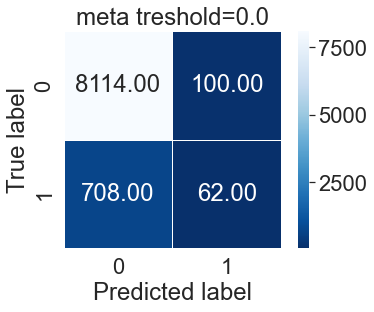

AUC 0.5341725720104098   
F1 0.1330472103004292   
Acc 0.9100623330365093   
spelade per lopp: 0.2163846838824577


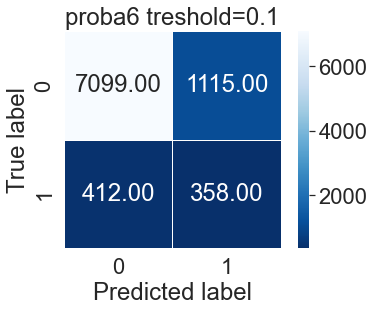

AUC 0.6645956064874984   
F1 0.31921533660276413   
Acc 0.8300311665182547   
spelade per lopp: 1.9674977738201247


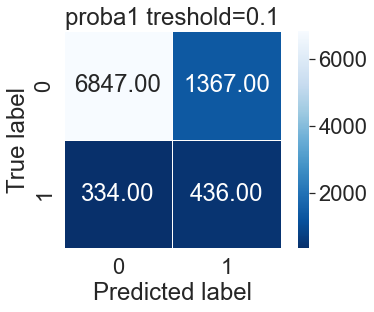

AUC 0.6999052931485364   
F1 0.33890400310921104   
Acc 0.8106634016028496   
spelade per lopp: 2.408281389136242


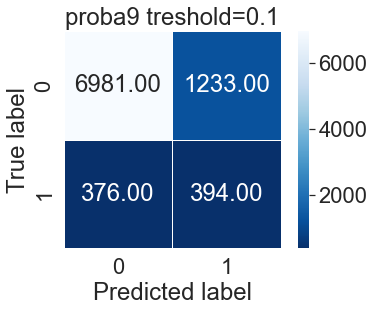

AUC 0.6807893713299118   
F1 0.32874426366291193   
Acc 0.8209038290293855   
spelade per lopp: 2.1731967943009796


In [73]:
validate( meta_model=meta_model, drop=[])  

Final Learning

In [74]:
final_stacked_data = final_learning(typer, n_splits=5, learn_models=True)


Step 1: Final learn models and produce the stacked data
shape of X (45073, 78)
sista datum 2022-06-04 resp 2022-06-04

shape of X_train (7513, 78) shape of X_test (7512, 78)
enum 0
   typ6
   best_iteration 45
   typ1
   best_iteration 67
   typ9
   best_iteration 58

shape of X_train (15025, 78) shape of X_test (7512, 78)
enum 1
   typ6
   best_iteration 36
   typ1
   best_iteration 29
   typ9
   best_iteration 30

shape of X_train (22537, 78) shape of X_test (7512, 78)
enum 2
   typ6
   best_iteration 23
   typ1
   best_iteration 37
   typ9
   best_iteration 30

shape of X_train (30049, 78) shape of X_test (7512, 78)
enum 3
   typ6
   best_iteration 43
   typ1
   best_iteration 53
   typ9
   best_iteration 34

shape of X_train (37561, 78) shape of X_test (7512, 78)
enum 4
   typ6
   best_iteration 27
   typ1
   best_iteration 35
   typ9
   best_iteration 27

Full X learning
typ6
typ1
typ9
Null values proba6    0
proba1    0
proba9    0
kelly6    0
kelly1    0
kelly9    0
y         0


In [75]:
meta='knn'
meta_model = learn_meta_model(final_stacked_data.drop(['y'], 
                              axis=1), final_stacked_data['y'], alpha=0.001, max_iter=55, n_estimators=360, max_depth=5, meta='knn', class_weight=None)
print(meta_model)

if meta=='knn':
    pass 
else:
    # print(meta_model.coef_)
    # l = list(zip(final_stacked_data.columns, np.round(meta_model.coef_, 22)))

    l = list(zip(stacked_data.columns, np.round(meta_model.feature_importances_, 4)))
    l.sort(key=lambda x: x[1], reverse=True)
    print('feature imp:', l)

KNeighborsClassifier(leaf_size=1, metric='chebyshev', n_jobs=6, n_neighbors=600,
                     p=1, weights='distance')


# Check out meta models

In [ ]:
###############################################################################
#                  optimize models                                            #
###############################################################################


In [84]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# 0.814077	{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 1000, 'p': 1, 'weights': 'distance'}
# 0.814750	{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 2000, 'p': 1, 'weights': 'distance'}
# uppdatera ovan och i app_learn

model_params = {
    'knn': {
        'model': KNeighborsClassifier(n_jobs=6),
        'params': {
            'algorithm': ['auto'],
            'leaf_size': [1, 5, 30],
            'metric': ['euclidean', 'manhattan', 'chebyshev'],
            'n_neighbors': [5, 75, 130, 500, 600, 700,1000, 1500, 2000, 4000],
            'p': [1, 2],
            'weights': ['uniform', 'distance'],
        }
    },
    'lasso': {
        'model': Lasso(random_state=2022),
        'params': {
            'alpha': [0.00001, 0.00002, 0.00003, 0.0001, 0.0002, 0.0005],
            'max_iter': [55, 30, 40, 50, 55,70,100,500,1000],
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(n_jobs=4, random_state=2022),
        'params': {
            'n_estimators': [300, 366, 400, 500],
            'max_depth': [ 5, 6, 8],
            'class_weight': [None],
        }
    },
    'ridge': {  
        'model': RidgeClassifier(random_state=2022),
        'params': {
            'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100],
            'class_weight': [None],
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [1, 5, 10]
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {'priors': [None]}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 3, 4, 5,6],

        }
    }
}


In [85]:
from sklearn.model_selection import GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
# final_stacked_data = final_learning(typer, n_splits=5, learn_models=True)

display(pd.read_csv('grid_search_meta_results.csv').sort_values(by='best_score', ascending=False))
scores = []

for model_name, mp in model_params.items():
    print(model_name,end=', ')
    clf = GridSearchCV(mp['model'], mp['params'], n_jobs=4, 
                       cv=tscv.split(final_stacked_data.drop(['y'], axis=1)), 
                       scoring='roc_auc',  
                       return_train_score=False
                      )
    
    clf.fit(final_stacked_data.drop(['y'],axis=1), final_stacked_data['y'])
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    print('best_score =', clf.best_score_, clf.best_params_)
df_grid = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params']).sort_values(by='best_score', ascending=False)
df_grid.to_csv('grid_search_meta_results.csv', index=False)
df_grid


,model,best_score,best_params
0,logistic_regression,0.816218,{'C': 5}
1,knn,0.814750,"{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 2000, 'p': 1, 'weights': 'distance'}"
2,ridge,0.813809,"{'alpha': 1, 'class_weight': None}"
3,lasso,0.813564,"{'alpha': 2e-05, 'max_iter': 1000}"
4,random_forest,0.809576,"{'class_weight': None, 'max_depth': 5, 'n_estimators': 500}"
5,decision_tree,0.797362,"{'criterion': 'entropy', 'max_depth': 4}"
6,naive_bayes_gaussian,0.791852,{'priors': None}


knn, best_score = 0.8147495066626048 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 2000, 'p': 1, 'weights': 'distance'}
lasso, best_score = 0.8135635915562999 {'alpha': 2e-05, 'max_iter': 1000}
random_forest, best_score = 0.8095759751502267 {'class_weight': None, 'max_depth': 5, 'n_estimators': 500}
ridge, best_score = 0.8138085904751527 {'alpha': 1, 'class_weight': None}
logistic_regression, best_score = 0.8162179691146931 {'C': 5}
naive_bayes_gaussian, best_score = 0.791851776412239 {'priors': None}
decision_tree, best_score = 0.7977656570021961 {'criterion': 'entropy', 'max_depth': 4}


,model,best_score,best_params
4,logistic_regression,0.816218,{'C': 5}
0,knn,0.814750,"{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 2000, 'p': 1, 'weights': 'distance'}"
3,ridge,0.813809,"{'alpha': 1, 'class_weight': None}"
1,lasso,0.813564,"{'alpha': 2e-05, 'max_iter': 1000}"
2,random_forest,0.809576,"{'class_weight': None, 'max_depth': 5, 'n_estimators': 500}"
6,decision_tree,0.797766,"{'criterion': 'entropy', 'max_depth': 4}"
5,naive_bayes_gaussian,0.791852,{'priors': None}


In [ ]:
display(pd.read_csv('grid_search_meta_results.csv').sort_values(by='best_score', ascending=False))
